In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#%autoreload # When utils.py is updated
from utils_unet_resunet import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from model.models import Model_3
from model.losses import WBCE
from model.callbacks import UpdateWeights
from multiprocessing.pool import Pool

root_path = 'imgs/' 

In [3]:
# Define data type 
img_type = 'FUSION'

if img_type == 'FUSION':
    image_array = np.load(root_path+'New_Images/fus_stack.npy')
    

if img_type == 'OPT':
    image_array = np.load(root_path+'New_Images/opt_stack.npy')
    
    
if img_type == 'SAR':
    image_array = np.load(root_path+'New_Images/sar_stack.npy')
print('Image stack:', image_array.shape)

final_mask1 = np.load(root_path+'New_Images/'+'final_mask1.npy')
print('Labels stack:', final_mask1.shape)

h_, w_, channels = image_array.shape
n_opt_layers = 20

Image stack: (10000, 7000, 24)
Labels stack: (10000, 7000)


In [4]:
# Create tile mask
mask_tiles = create_mask(final_mask1.shape[0], final_mask1.shape[1], grid_size=(5, 4))
image_array = image_array[:mask_tiles.shape[0], :mask_tiles.shape[1],:]
final_mask1 = final_mask1[:mask_tiles.shape[0], :mask_tiles.shape[1]]

print('mask: ',mask_tiles.shape)
print('image stack: ', image_array.shape)
print('ref :', final_mask1.shape)
#plt.imshow(mask_tiles)

Tiles size:  2000 1750
Mask size:  (10000, 7000)
mask:  (10000, 7000)
image stack:  (10000, 7000, 24)
ref : (10000, 7000)


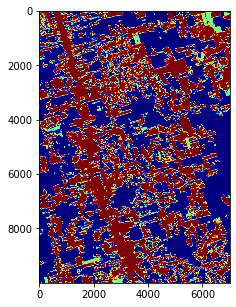

In [5]:
plt.figure(figsize=(10,5))
plt.imshow(final_mask1, cmap = 'jet')

In [6]:
# Define tiles for training, validation, and test sets
tiles_tr = [1,3,5,8,11,13,14,20]
tiles_val = [6,19]
tiles_ts = (list(set(np.arange(20)+1)-set(tiles_tr)-set(tiles_val)))

mask_tr_val = np.zeros((mask_tiles.shape)).astype('float32')
# Training and validation mask
for tr_ in tiles_tr:
    mask_tr_val[mask_tiles == tr_] = 1

for val_ in tiles_val:
    mask_tr_val[mask_tiles == val_] = 2

mask_amazon_ts = np.zeros((mask_tiles.shape)).astype('float32')
for ts_ in tiles_ts:
    mask_amazon_ts[mask_tiles == ts_] = 1

In [7]:
# Create ixd image to extract patches
overlap = 0.7
patch_size = 128
batch_size = 32
im_idx = create_idx_image(final_mask1)
patches_idx = extract_patches(im_idx, patch_size=(patch_size, patch_size), overlap=overlap).reshape(-1,patch_size, patch_size)
patches_mask = extract_patches(mask_tr_val, patch_size=(patch_size, patch_size), overlap=overlap).reshape(-1, patch_size, patch_size)
del im_idx

In [8]:
# Selecting index trn val and test patches idx
idx_trn = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==patch_size**2))
idx_val = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==2*patch_size**2))
del patches_mask

patches_idx_trn = patches_idx[idx_trn]
patches_idx_val = patches_idx[idx_val]
del idx_trn, idx_val

print('Number of training patches:  ', len(patches_idx_trn), 'Number of validation patches', len(patches_idx_val))

Number of training patches:   17110 Number of validation patches 4116


In [9]:
# Extract patches with at least 2% of deforestation class
X_train = retrieve_idx_percentage(final_mask1, patches_idx_trn, patch_size, pertentage = 2)
X_valid = retrieve_idx_percentage(final_mask1, patches_idx_val, patch_size, pertentage = 2)
print(X_train.shape, X_valid.shape)
del patches_idx_trn, patches_idx_val

(1158, 128, 128) (341, 128, 128)


In [10]:
def batch_generator(batches, image, reference, target_size, number_class):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    image = image.reshape(-1, image.shape[-1])
    reference = reference.reshape(final_mask1.shape[0]*final_mask1.shape[1])
    while True:
        batch_x, batch_y = next(batches)
        batch_x = np.squeeze(batch_x.astype('int64'))
        #print(batch_x.shape)
        batch_img = np.zeros((batch_x.shape[0], target_size, target_size, image.shape[-1]))
        batch_ref = np.zeros((batch_x.shape[0], target_size, target_size, number_class))
        
        for i in range(batch_x.shape[0]):
            if np.random.rand()>0.5:
                batch_x[i] = np.rot90(batch_x[i], 1)
            batch_img[i] = image[batch_x[i]] 
            batch_ref[i] = tf.keras.utils.to_categorical(reference[batch_x[i]] , number_class)
                       
        yield (batch_img, batch_ref)

train_datagen = ImageDataGenerator(horizontal_flip = True,
                                   vertical_flip = True)
valid_datagen = ImageDataGenerator(horizontal_flip = True, 
                                   vertical_flip = True)

y_train = np.zeros((len(X_train)))
y_valid = np.zeros((len(X_valid)))

train_gen = train_datagen.flow(np.expand_dims(X_train, axis = -1), y_train,
                              batch_size=batch_size,
                              shuffle=True)

valid_gen = valid_datagen.flow(np.expand_dims(X_valid, axis = -1), y_valid,
                              batch_size=batch_size,
                              shuffle=False)

number_class = 3
train_gen_crops = batch_generator(train_gen, image_array, final_mask1, patch_size, number_class)
valid_gen_crops = batch_generator(valid_gen, image_array, final_mask1, patch_size, number_class)


In [11]:
exp = 3
path_exp = root_path+'experiments/exp'+str(exp)
path_models = path_exp+'/models'
path_maps = path_exp+'/pred_maps'

if not os.path.exists(path_exp):
    os.makedirs(path_exp)   
if not os.path.exists(path_models):
    os.makedirs(path_models)   
if not os.path.exists(path_maps):
    os.makedirs(path_maps)

In [12]:
# Define model
input_shape = (patch_size, patch_size, channels)
nb_filters = [32, 64, 128]

method = 'unet'
if method == 'unet':
   model = build_unet(input_shape, nb_filters, number_class)

if method == 'resunet':
   model = build_resunet(input_shape, nb_filters, number_class)

model = Model_3(nb_filters, number_class, n_opt_layers)

In [13]:
# Parameters of the model
weights = [0.2, 0.8, 0]
adam = Adam(lr = 1e-4 , beta_1=0.9)
loss = weighted_categorical_crossentropy(weights)
#loss = WBCE(weights = weights)
#loss = WBCE(weights = weights, class_indexes = [0, 1])


In [14]:
metrics_all = []
times=30
for tm in range(0,times):
    print('time: ', tm)

    rows = patch_size
    cols = patch_size
    adam = Adam(lr = 1e-4 , beta_1=0.9)
    
    loss = weighted_categorical_crossentropy(weights)
    #loss = WBCE(weights = weights)
    #loss = WBCE(weights = weights, class_indexes = [0, 1])

    #if method == 'unet':
    #   model = build_unet(input_shape, nb_filters, number_class)

    #if method == 'resunet':
    #   model = build_resunet(input_shape, nb_filters, number_class)
    
    model = Model_3(nb_filters, number_class, n_opt_layers)
    model.build((None,)+input_shape)
    
    model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])
    model.summary()

    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
    #earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min') ---- val_accuracy
    #checkpoint = ModelCheckpoint(path_models+ '/' + method +'_'+str(tm)+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    checkpoint = ModelCheckpoint(path_models+ '/' + method +'_'+str(tm)+'.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')
    lr_reduce = ReduceLROnPlateau(factor=0.9, min_delta=0.0001, patience=5, verbose=1)
    updateWeights = UpdateWeights()
    callbacks_list = [earlystop, checkpoint, updateWeights]
    # train the model
    start_training = time.time()
    history = model.fit(train_gen_crops,
                              steps_per_epoch=len(X_train)*3//train_gen.batch_size,
                              validation_data=valid_gen_crops,
                              validation_steps=len(X_valid)*3//valid_gen.batch_size,
                              epochs=100,
                              callbacks=callbacks_list)
    end_training = time.time() - start_training
    metrics_all.append(end_training)
    del model, history

time:  0
Model: "model_3_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
opt_encoder (UNET_Encoder)   multiple                  540896    
_________________________________________________________________
sar_encoder (UNET_Encoder)   multiple                  536288    
_________________________________________________________________
shared_decoder (UNET_Decoder multiple                  332000    
_________________________________________________________________
opt_classifier (Classifier)  multiple                  195       
_________________________________________________________________
sar_classifier (Classifier)  multiple                  195       
_________________________________________________________________
fus_classifier (Classifier)  multiple                  195       
_________________________________________________________________
combination (CombinationLaye multiple           

Epoch 1/100
108/108 [==============================] - 18s 149ms/step - opt_accuracy: 0.8020 - sar_accuracy: 0.6706 - fus_accuracy: 0.7458 - opt_loss: 0.1177 - sar_loss: 1.5834 - fusion_loss: 0.1333 - loss: 1.8344 - val_opt_accuracy: 0.8632 - val_sar_accuracy: 0.7700 - val_fus_accuracy: 0.8413 - val_opt_loss: 0.0826 - val_sar_loss: 1.1791 - val_fusion_loss: 0.0909 - val_loss: 1.3526

Epoch 00001: val_loss improved from inf to 1.35262, saving model to imgs/experiments/exp3/models\unet_1.h5
Epoch 2/100
108/108 [==============================] - 16s 147ms/step - opt_accuracy: 0.8511 - sar_accuracy: 0.7301 - fus_accuracy: 0.8141 - opt_loss: 0.0909 - sar_loss: 1.4067 - fusion_loss: 0.0994 - loss: 1.5970 - val_opt_accuracy: 0.8603 - val_sar_accuracy: 0.7729 - val_fus_accuracy: 0.8494 - val_opt_loss: 0.0952 - val_sar_loss: 1.2099 - val_fusion_loss: 0.1031 - val_loss: 1.4083

Epoch 00002: val_loss did not improve from 1.35262
Epoch 3/100
108/108 [==============================] - 16s 146ms/ste


Epoch 00003: val_loss did not improve from 1.34753
Epoch 4/100
108/108 [==============================] - 16s 147ms/step - opt_accuracy: 0.8614 - sar_accuracy: 0.7602 - fus_accuracy: 0.8606 - opt_loss: 0.0752 - sar_loss: 1.2228 - fusion_loss: 0.0808 - loss: 1.3787 - val_opt_accuracy: 0.8633 - val_sar_accuracy: 0.7935 - val_fus_accuracy: 0.8634 - val_opt_loss: 0.1132 - val_sar_loss: 1.2183 - val_fusion_loss: 0.1086 - val_loss: 1.4401

Epoch 00004: val_loss did not improve from 1.34753
Epoch 5/100
108/108 [==============================] - 16s 148ms/step - opt_accuracy: 0.8672 - sar_accuracy: 0.7679 - fus_accuracy: 0.8645 - opt_loss: 0.0722 - sar_loss: 1.2040 - fusion_loss: 0.0776 - loss: 1.3538 - val_opt_accuracy: 0.8614 - val_sar_accuracy: 0.7918 - val_fus_accuracy: 0.8652 - val_opt_loss: 0.1375 - val_sar_loss: 1.1896 - val_fusion_loss: 0.1244 - val_loss: 1.4515

Epoch 00005: val_loss did not improve from 1.34753
Epoch 6/100
108/108 [==============================] - 16s 148ms/step - 


Epoch 00007: val_loss did not improve from 1.32196
Epoch 8/100
108/108 [==============================] - 16s 152ms/step - opt_accuracy: 0.8852 - sar_accuracy: 0.7818 - fus_accuracy: 0.8721 - opt_loss: 0.0613 - sar_loss: 1.1974 - fusion_loss: 0.0667 - loss: 1.3254 - val_opt_accuracy: 0.8644 - val_sar_accuracy: 0.8061 - val_fus_accuracy: 0.8659 - val_opt_loss: 0.1069 - val_sar_loss: 1.1015 - val_fusion_loss: 0.0998 - val_loss: 1.3083

Epoch 00008: val_loss improved from 1.32196 to 1.30827, saving model to imgs/experiments/exp3/models\unet_3.h5
Epoch 9/100
108/108 [==============================] - 16s 152ms/step - opt_accuracy: 0.8889 - sar_accuracy: 0.7777 - fus_accuracy: 0.8754 - opt_loss: 0.0581 - sar_loss: 1.2091 - fusion_loss: 0.0635 - loss: 1.3307 - val_opt_accuracy: 0.8606 - val_sar_accuracy: 0.8027 - val_fus_accuracy: 0.8613 - val_opt_loss: 0.1283 - val_sar_loss: 1.1132 - val_fusion_loss: 0.1212 - val_loss: 1.3627

Epoch 00009: val_loss did not improve from 1.30827
Epoch 10/100

108/108 [==============================] - 17s 156ms/step - opt_accuracy: 0.8699 - sar_accuracy: 0.7515 - fus_accuracy: 0.8562 - opt_loss: 0.0768 - sar_loss: 1.2878 - fusion_loss: 0.0896 - loss: 1.4541 - val_opt_accuracy: 0.8692 - val_sar_accuracy: 0.7944 - val_fus_accuracy: 0.8705 - val_opt_loss: 0.0920 - val_sar_loss: 1.1523 - val_fusion_loss: 0.0884 - val_loss: 1.3327

Epoch 00004: val_loss improved from 1.37132 to 1.33266, saving model to imgs/experiments/exp3/models\unet_4.h5
Epoch 5/100
108/108 [==============================] - 17s 157ms/step - opt_accuracy: 0.8746 - sar_accuracy: 0.7617 - fus_accuracy: 0.8622 - opt_loss: 0.0738 - sar_loss: 1.2485 - fusion_loss: 0.0846 - loss: 1.4069 - val_opt_accuracy: 0.8694 - val_sar_accuracy: 0.7958 - val_fus_accuracy: 0.8718 - val_opt_loss: 0.0869 - val_sar_loss: 1.0937 - val_fusion_loss: 0.0834 - val_loss: 1.2640

Epoch 00005: val_loss improved from 1.33266 to 1.26401, saving model to imgs/experiments/exp3/models\unet_4.h5
Epoch 6/100
108/

108/108 [==============================] - 18s 165ms/step - opt_accuracy: 0.8645 - sar_accuracy: 0.7613 - fus_accuracy: 0.8426 - opt_loss: 0.0769 - sar_loss: 1.2762 - fusion_loss: 0.0847 - loss: 1.4379 - val_opt_accuracy: 0.8628 - val_sar_accuracy: 0.7877 - val_fus_accuracy: 0.8616 - val_opt_loss: 0.0933 - val_sar_loss: 1.1632 - val_fusion_loss: 0.0983 - val_loss: 1.3548

Epoch 00004: val_loss improved from 1.35820 to 1.35482, saving model to imgs/experiments/exp3/models\unet_5.h5
Epoch 5/100
108/108 [==============================] - 18s 165ms/step - opt_accuracy: 0.8676 - sar_accuracy: 0.7674 - fus_accuracy: 0.8475 - opt_loss: 0.0741 - sar_loss: 1.2473 - fusion_loss: 0.0810 - loss: 1.4023 - val_opt_accuracy: 0.8658 - val_sar_accuracy: 0.7816 - val_fus_accuracy: 0.8638 - val_opt_loss: 0.0916 - val_sar_loss: 1.1579 - val_fusion_loss: 0.0976 - val_loss: 1.3471

Epoch 00005: val_loss improved from 1.35482 to 1.34705, saving model to imgs/experiments/exp3/models\unet_5.h5
Epoch 6/100
108/

108/108 [==============================] - 19s 173ms/step - opt_accuracy: 0.9200 - sar_accuracy: 0.7705 - fus_accuracy: 0.9147 - opt_loss: 0.0375 - sar_loss: 1.1912 - fusion_loss: 0.0390 - loss: 1.2677 - val_opt_accuracy: 0.8640 - val_sar_accuracy: 0.7942 - val_fus_accuracy: 0.8638 - val_opt_loss: 0.1728 - val_sar_loss: 1.1997 - val_fusion_loss: 0.1688 - val_loss: 1.5413

Epoch 00022: val_loss did not improve from 1.28042
Epoch 00022: early stopping
time:  6
Model: "model_3_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
opt_encoder (UNET_Encoder)   multiple                  540896    
_________________________________________________________________
sar_encoder (UNET_Encoder)   multiple                  536288    
_________________________________________________________________
shared_decoder (UNET_Decoder multiple                  332000    
________________________________________________________

108/108 [==============================] - 20s 188ms/step - opt_accuracy: 0.9025 - sar_accuracy: 0.7592 - fus_accuracy: 0.8947 - opt_loss: 0.0467 - sar_loss: 1.2450 - fusion_loss: 0.0516 - loss: 1.3432 - val_opt_accuracy: 0.8593 - val_sar_accuracy: 0.7953 - val_fus_accuracy: 0.8590 - val_opt_loss: 0.1255 - val_sar_loss: 1.1249 - val_fusion_loss: 0.1313 - val_loss: 1.3817

Epoch 00015: val_loss did not improve from 1.32221
Epoch 16/100
108/108 [==============================] - 20s 188ms/step - opt_accuracy: 0.9033 - sar_accuracy: 0.7582 - fus_accuracy: 0.8956 - opt_loss: 0.0470 - sar_loss: 1.2519 - fusion_loss: 0.0518 - loss: 1.3506 - val_opt_accuracy: 0.8631 - val_sar_accuracy: 0.7882 - val_fus_accuracy: 0.8635 - val_opt_loss: 0.1415 - val_sar_loss: 1.1217 - val_fusion_loss: 0.1439 - val_loss: 1.4071

Epoch 00016: val_loss did not improve from 1.32221
Epoch 17/100
108/108 [==============================] - 20s 189ms/step - opt_accuracy: 0.9060 - sar_accuracy: 0.7586 - fus_accuracy: 0.


Epoch 00008: val_loss did not improve from 1.31937
Epoch 9/100
108/108 [==============================] - 23s 214ms/step - opt_accuracy: 0.8800 - sar_accuracy: 0.7569 - fus_accuracy: 0.8612 - opt_loss: 0.0661 - sar_loss: 1.2723 - fusion_loss: 0.0748 - loss: 1.4132 - val_opt_accuracy: 0.8586 - val_sar_accuracy: 0.7979 - val_fus_accuracy: 0.8543 - val_opt_loss: 0.1105 - val_sar_loss: 1.1234 - val_fusion_loss: 0.1105 - val_loss: 1.3444

Epoch 00009: val_loss did not improve from 1.31937
Epoch 10/100
108/108 [==============================] - 23s 216ms/step - opt_accuracy: 0.8840 - sar_accuracy: 0.7593 - fus_accuracy: 0.8660 - opt_loss: 0.0638 - sar_loss: 1.2551 - fusion_loss: 0.0716 - loss: 1.3905 - val_opt_accuracy: 0.8651 - val_sar_accuracy: 0.7745 - val_fus_accuracy: 0.8652 - val_opt_loss: 0.1004 - val_sar_loss: 1.1979 - val_fusion_loss: 0.0982 - val_loss: 1.3965

Epoch 00010: val_loss did not improve from 1.31937
Epoch 11/100
108/108 [==============================] - 23s 217ms/step 


Epoch 00012: val_loss improved from 1.32810 to 1.30733, saving model to imgs/experiments/exp3/models\unet_8.h5
Epoch 13/100
108/108 [==============================] - 26s 243ms/step - opt_accuracy: 0.9044 - sar_accuracy: 0.7729 - fus_accuracy: 0.8960 - opt_loss: 0.0499 - sar_loss: 1.1975 - fusion_loss: 0.0535 - loss: 1.3010 - val_opt_accuracy: 0.8587 - val_sar_accuracy: 0.7924 - val_fus_accuracy: 0.8599 - val_opt_loss: 0.1446 - val_sar_loss: 1.1138 - val_fusion_loss: 0.1398 - val_loss: 1.398239 - sar_accuracy: 0.7730 - fus_accuracy: 0.8954 - opt_loss: 0.0503 - sar_loss: 1.1947 - fusion_loss: 0.0539 - loss - ETA: 4s - opt_accuracy: 0.9041 - sar_accuracy: 0.7727 - fus_accuracy: 0.8957 - opt_loss: 0.0503 -

Epoch 00013: val_loss did not improve from 1.30733
Epoch 14/100
108/108 [==============================] - 28s 257ms/step - opt_accuracy: 0.9078 - sar_accuracy: 0.7653 - fus_accuracy: 0.8997 - opt_loss: 0.0475 - sar_loss: 1.2268 - fusion_loss: 0.0507 - loss: 1.3250 - val_opt_accuracy:

108/108 [==============================] - 28s 258ms/step - opt_accuracy: 0.8646 - sar_accuracy: 0.7580 - fus_accuracy: 0.8430 - opt_loss: 0.0770 - sar_loss: 1.2557 - fusion_loss: 0.0901 - loss: 1.4228 - val_opt_accuracy: 0.8485 - val_sar_accuracy: 0.7636 - val_fus_accuracy: 0.8476 - val_opt_loss: 0.0950 - val_sar_loss: 1.2535 - val_fusion_loss: 0.1016 - val_loss: 1.4501

Epoch 00004: val_loss did not improve from 1.34761
Epoch 5/100
108/108 [==============================] - 28s 262ms/step - opt_accuracy: 0.8714 - sar_accuracy: 0.7614 - fus_accuracy: 0.8521 - opt_loss: 0.0726 - sar_loss: 1.2446 - fusion_loss: 0.0845 - loss: 1.4016 - val_opt_accuracy: 0.8514 - val_sar_accuracy: 0.7661 - val_fus_accuracy: 0.8525 - val_opt_loss: 0.0994 - val_sar_loss: 1.2443 - val_fusion_loss: 0.1037 - val_loss: 1.4474

Epoch 00005: val_loss did not improve from 1.34761
Epoch 6/100
108/108 [==============================] - 28s 264ms/step - opt_accuracy: 0.8768 - sar_accuracy: 0.7698 - fus_accuracy: 0.85

108/108 [==============================] - 31s 287ms/step - opt_accuracy: 0.8852 - sar_accuracy: 0.7859 - fus_accuracy: 0.8780 - opt_loss: 0.0622 - sar_loss: 1.1483 - fusion_loss: 0.0656 - loss: 1.2761 - val_opt_accuracy: 0.8598 - val_sar_accuracy: 0.8121 - val_fus_accuracy: 0.8637 - val_opt_loss: 0.1237 - val_sar_loss: 1.2740 - val_fusion_loss: 0.1274 - val_loss: 1.5251

Epoch 00008: val_loss did not improve from 1.33473
Epoch 9/100
108/108 [==============================] - 31s 286ms/step - opt_accuracy: 0.8887 - sar_accuracy: 0.7869 - fus_accuracy: 0.8813 - opt_loss: 0.0599 - sar_loss: 1.1492 - fusion_loss: 0.0631 - loss: 1.2722 - val_opt_accuracy: 0.8646 - val_sar_accuracy: 0.7923 - val_fus_accuracy: 0.8618 - val_opt_loss: 0.1088 - val_sar_loss: 1.2144 - val_fusion_loss: 0.1101 - val_loss: 1.4333

Epoch 00009: val_loss did not improve from 1.33473
Epoch 10/100
108/108 [==============================] - 34s 314ms/step - opt_accuracy: 0.8934 - sar_accuracy: 0.7868 - fus_accuracy: 0.8


Epoch 00001: val_loss improved from inf to 1.32805, saving model to imgs/experiments/exp3/models\unet_11.h5
Epoch 2/100
108/108 [==============================] - 33s 308ms/step - opt_accuracy: 0.8499 - sar_accuracy: 0.7431 - fus_accuracy: 0.8194 - opt_loss: 0.0872 - sar_loss: 1.3531 - fusion_loss: 0.1045 - loss: 1.5448 - val_opt_accuracy: 0.8608 - val_sar_accuracy: 0.7766 - val_fus_accuracy: 0.8617 - val_opt_loss: 0.0991 - val_sar_loss: 1.1610 - val_fusion_loss: 0.0954 - val_loss: 1.3555

Epoch 00002: val_loss did not improve from 1.32805
Epoch 3/100
108/108 [==============================] - 33s 309ms/step - opt_accuracy: 0.8598 - sar_accuracy: 0.7483 - fus_accuracy: 0.8315 - opt_loss: 0.0818 - sar_loss: 1.3370 - fusion_loss: 0.0958 - loss: 1.5146 - val_opt_accuracy: 0.8539 - val_sar_accuracy: 0.7820 - val_fus_accuracy: 0.8575 - val_opt_loss: 0.1153 - val_sar_loss: 1.1635 - val_fusion_loss: 0.1112 - val_loss: 1.3900

Epoch 00003: val_loss did not improve from 1.32805
Epoch 4/100
108

108/108 [==============================] - 35s 328ms/step - opt_accuracy: 0.8800 - sar_accuracy: 0.7816 - fus_accuracy: 0.8700 - opt_loss: 0.0654 - sar_loss: 1.2004 - fusion_loss: 0.0698 - loss: 1.3355 - val_opt_accuracy: 0.8605 - val_sar_accuracy: 0.7824 - val_fus_accuracy: 0.8613 - val_opt_loss: 0.1124 - val_sar_loss: 1.1850 - val_fusion_loss: 0.1068 - val_loss: 1.4042

Epoch 00006: val_loss did not improve from 1.30097
Epoch 7/100
108/108 [==============================] - 35s 328ms/step - opt_accuracy: 0.8850 - sar_accuracy: 0.7857 - fus_accuracy: 0.8769 - opt_loss: 0.0617 - sar_loss: 1.1807 - fusion_loss: 0.0654 - loss: 1.3078 - val_opt_accuracy: 0.8627 - val_sar_accuracy: 0.7964 - val_fus_accuracy: 0.8620 - val_opt_loss: 0.1200 - val_sar_loss: 1.1239 - val_fusion_loss: 0.1177 - val_loss: 1.3617

Epoch 00007: val_loss did not improve from 1.30097
Epoch 8/100
108/108 [==============================] - 36s 333ms/step - opt_accuracy: 0.8899 - sar_accuracy: 0.7875 - fus_accuracy: 0.88


Epoch 00010: val_loss did not improve from 1.31912
Epoch 11/100
108/108 [==============================] - 38s 351ms/step - opt_accuracy: 0.8930 - sar_accuracy: 0.7761 - fus_accuracy: 0.8846 - opt_loss: 0.0567 - sar_loss: 1.2103 - fusion_loss: 0.0601 - loss: 1.3271 - val_opt_accuracy: 0.8624 - val_sar_accuracy: 0.7972 - val_fus_accuracy: 0.8627 - val_opt_loss: 0.0985 - val_sar_loss: 1.1393 - val_fusion_loss: 0.0970 - val_loss: 1.3348

Epoch 00011: val_loss did not improve from 1.31912
Epoch 00011: early stopping
time:  14
Model: "model_3_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
opt_encoder (UNET_Encoder)   multiple                  540896    
_________________________________________________________________
sar_encoder (UNET_Encoder)   multiple                  536288    
_________________________________________________________________
shared_decoder (UNET_Decoder multiple                  

108/108 [==============================] - 44s 383ms/step - opt_accuracy: 0.8009 - sar_accuracy: 0.7086 - fus_accuracy: 0.7544 - opt_loss: 0.1109 - sar_loss: 1.4957 - fusion_loss: 0.1386 - loss: 1.7452 - val_opt_accuracy: 0.8634 - val_sar_accuracy: 0.7814 - val_fus_accuracy: 0.8641 - val_opt_loss: 0.0828 - val_sar_loss: 1.1393 - val_fusion_loss: 0.0816 - val_loss: 1.3036

Epoch 00001: val_loss improved from inf to 1.30362, saving model to imgs/experiments/exp3/models\unet_15.h5
Epoch 2/100
108/108 [==============================] - 40s 375ms/step - opt_accuracy: 0.8484 - sar_accuracy: 0.7473 - fus_accuracy: 0.8276 - opt_loss: 0.0859 - sar_loss: 1.3518 - fusion_loss: 0.0995 - loss: 1.5372 - val_opt_accuracy: 0.8583 - val_sar_accuracy: 0.7745 - val_fus_accuracy: 0.8676 - val_opt_loss: 0.0917 - val_sar_loss: 1.2152 - val_fusion_loss: 0.0885 - val_loss: 1.3954

Epoch 00002: val_loss did not improve from 1.30362
Epoch 3/100
108/108 [==============================] - 40s 370ms/step - opt_acc

108/108 [==============================] - 42s 394ms/step - opt_accuracy: 0.8766 - sar_accuracy: 0.7683 - fus_accuracy: 0.8634 - opt_loss: 0.0688 - sar_loss: 1.2350 - fusion_loss: 0.0750 - loss: 1.3788 - val_opt_accuracy: 0.8523 - val_sar_accuracy: 0.7973 - val_fus_accuracy: 0.8590 - val_opt_loss: 0.1297 - val_sar_loss: 1.1677 - val_fusion_loss: 0.1113 - val_loss: 1.4088

Epoch 00005: val_loss did not improve from 1.31913
Epoch 6/100
108/108 [==============================] - 43s 398ms/step - opt_accuracy: 0.8825 - sar_accuracy: 0.7718 - fus_accuracy: 0.8695 - opt_loss: 0.0660 - sar_loss: 1.2116 - fusion_loss: 0.0718 - loss: 1.3494 - val_opt_accuracy: 0.8606 - val_sar_accuracy: 0.7781 - val_fus_accuracy: 0.8592 - val_opt_loss: 0.1108 - val_sar_loss: 1.2420 - val_fusion_loss: 0.1025 - val_loss: 1.4552

Epoch 00006: val_loss did not improve from 1.31913
Epoch 7/100
108/108 [==============================] - 43s 398ms/step - opt_accuracy: 0.8868 - sar_accuracy: 0.7786 - fus_accuracy: 0.87

108/108 [==============================] - 44s 414ms/step - opt_accuracy: 0.8863 - sar_accuracy: 0.7844 - fus_accuracy: 0.8645 - opt_loss: 0.0652 - sar_loss: 1.1590 - fusion_loss: 0.0750 - loss: 1.2991 - val_opt_accuracy: 0.8606 - val_sar_accuracy: 0.7909 - val_fus_accuracy: 0.8660 - val_opt_loss: 0.0860 - val_sar_loss: 1.1096 - val_fusion_loss: 0.0845 - val_loss: 1.2801

Epoch 00009: val_loss improved from 1.29897 to 1.28009, saving model to imgs/experiments/exp3/models\unet_17.h5
Epoch 10/100
108/108 [==============================] - 45s 414ms/step - opt_accuracy: 0.8876 - sar_accuracy: 0.7942 - fus_accuracy: 0.8662 - opt_loss: 0.0641 - sar_loss: 1.1242 - fusion_loss: 0.0729 - loss: 1.2612 - val_opt_accuracy: 0.8609 - val_sar_accuracy: 0.8140 - val_fus_accuracy: 0.8677 - val_opt_loss: 0.1076 - val_sar_loss: 1.1334 - val_fusion_loss: 0.0967 - val_loss: 1.3377

Epoch 00010: val_loss did not improve from 1.28009
Epoch 11/100
108/108 [==============================] - 46s 425ms/step - o

108/108 [==============================] - 48s 449ms/step - opt_accuracy: 0.8498 - sar_accuracy: 0.7554 - fus_accuracy: 0.8353 - opt_loss: 0.0832 - sar_loss: 1.3311 - fusion_loss: 0.0891 - loss: 1.5034 - val_opt_accuracy: 0.8628 - val_sar_accuracy: 0.7921 - val_fus_accuracy: 0.8625 - val_opt_loss: 0.0957 - val_sar_loss: 1.1415 - val_fusion_loss: 0.0922 - val_loss: 1.3294

Epoch 00002: val_loss did not improve from 1.31206
Epoch 3/100
108/108 [==============================] - 48s 445ms/step - opt_accuracy: 0.8608 - sar_accuracy: 0.7659 - fus_accuracy: 0.8501 - opt_loss: 0.0781 - sar_loss: 1.2834 - fusion_loss: 0.0837 - loss: 1.4452 - val_opt_accuracy: 0.8578 - val_sar_accuracy: 0.7891 - val_fus_accuracy: 0.8590 - val_opt_loss: 0.1108 - val_sar_loss: 1.1636 - val_fusion_loss: 0.0998 - val_loss: 1.3742

Epoch 00003: val_loss did not improve from 1.31206
Epoch 4/100
108/108 [==============================] - 48s 445ms/step - opt_accuracy: 0.8677 - sar_accuracy: 0.7697 - fus_accuracy: 0.85


Epoch 00006: val_loss did not improve from 1.33857
Epoch 7/100
108/108 [==============================] - 49s 454ms/step - opt_accuracy: 0.8797 - sar_accuracy: 0.7865 - fus_accuracy: 0.8675 - opt_loss: 0.0651 - sar_loss: 1.1640 - fusion_loss: 0.0718 - loss: 1.3009 - val_opt_accuracy: 0.8665 - val_sar_accuracy: 0.8056 - val_fus_accuracy: 0.8659 - val_opt_loss: 0.0994 - val_sar_loss: 1.1660 - val_fusion_loss: 0.1057 - val_loss: 1.3712

Epoch 00007: val_loss did not improve from 1.33857
Epoch 8/100
108/108 [==============================] - 49s 461ms/step - opt_accuracy: 0.8855 - sar_accuracy: 0.7908 - fus_accuracy: 0.8739 - opt_loss: 0.0618 - sar_loss: 1.1478 - fusion_loss: 0.0676 - loss: 1.2771 - val_opt_accuracy: 0.8619 - val_sar_accuracy: 0.8087 - val_fus_accuracy: 0.8626 - val_opt_loss: 0.1107 - val_sar_loss: 1.1405 - val_fusion_loss: 0.1124 - val_loss: 1.3636

Epoch 00008: val_loss did not improve from 1.33857
Epoch 9/100
108/108 [==============================] - 49s 456ms/step - 

108/108 [==============================] - 55s 516ms/step - opt_accuracy: 0.9020 - sar_accuracy: 0.7907 - fus_accuracy: 0.8909 - opt_loss: 0.0510 - sar_loss: 1.1270 - fusion_loss: 0.0567 - loss: 1.2347 - val_opt_accuracy: 0.8630 - val_sar_accuracy: 0.8027 - val_fus_accuracy: 0.8622 - val_opt_loss: 0.1341 - val_sar_loss: 1.1004 - val_fusion_loss: 0.1246 - val_loss: 1.3591

Epoch 00011: val_loss did not improve from 1.30053
Epoch 12/100
108/108 [==============================] - 59s 546ms/step - opt_accuracy: 0.9049 - sar_accuracy: 0.7915 - fus_accuracy: 0.8943 - opt_loss: 0.0482 - sar_loss: 1.1245 - fusion_loss: 0.0533 - loss: 1.2259 - val_opt_accuracy: 0.8592 - val_sar_accuracy: 0.8008 - val_fus_accuracy: 0.8598 - val_opt_loss: 0.1209 - val_sar_loss: 1.0451 - val_fusion_loss: 0.1156 - val_loss: 1.2815

Epoch 00012: val_loss improved from 1.30053 to 1.28151, saving model to imgs/experiments/exp3/models\unet_20.h5
Epoch 13/100
108/108 [==============================] - 52s 486ms/step - o

108/108 [==============================] - 55s 509ms/step - opt_accuracy: 0.8617 - sar_accuracy: 0.7657 - fus_accuracy: 0.8410 - opt_loss: 0.0762 - sar_loss: 1.2603 - fusion_loss: 0.0871 - loss: 1.4236 - val_opt_accuracy: 0.8585 - val_sar_accuracy: 0.7933 - val_fus_accuracy: 0.8575 - val_opt_loss: 0.1153 - val_sar_loss: 1.1991 - val_fusion_loss: 0.1081 - val_loss: 1.4224

Epoch 00004: val_loss did not improve from 1.30874
Epoch 5/100
108/108 [==============================] - 55s 517ms/step - opt_accuracy: 0.8700 - sar_accuracy: 0.7742 - fus_accuracy: 0.8508 - opt_loss: 0.0717 - sar_loss: 1.2360 - fusion_loss: 0.0814 - loss: 1.3891 - val_opt_accuracy: 0.8579 - val_sar_accuracy: 0.7964 - val_fus_accuracy: 0.8576 - val_opt_loss: 0.1303 - val_sar_loss: 1.1707 - val_fusion_loss: 0.1170 - val_loss: 1.4180

Epoch 00005: val_loss did not improve from 1.30874
Epoch 6/100
108/108 [==============================] - 55s 515ms/step - opt_accuracy: 0.8746 - sar_accuracy: 0.7812 - fus_accuracy: 0.85


Epoch 00022: val_loss did not improve from 1.29520
Epoch 00022: early stopping
time:  22
Model: "model_3_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
opt_encoder (UNET_Encoder)   multiple                  540896    
_________________________________________________________________
sar_encoder (UNET_Encoder)   multiple                  536288    
_________________________________________________________________
shared_decoder (UNET_Decoder multiple                  332000    
_________________________________________________________________
opt_classifier (Classifier)  multiple                  195       
_________________________________________________________________
sar_classifier (Classifier)  multiple                  195       
_________________________________________________________________
fus_classifier (Classifier)  multiple                  195       
________________________________

108/108 [==============================] - 60s 561ms/step - opt_accuracy: 0.9147 - sar_accuracy: 0.8069 - fus_accuracy: 0.9111 - opt_loss: 0.0404 - sar_loss: 1.0477 - fusion_loss: 0.0416 - loss: 1.1296 - val_opt_accuracy: 0.8624 - val_sar_accuracy: 0.8115 - val_fus_accuracy: 0.8646 - val_opt_loss: 0.1915 - val_sar_loss: 1.2733 - val_fusion_loss: 0.1923 - val_loss: 1.6571

Epoch 00016: val_loss did not improve from 1.37258
Epoch 17/100
108/108 [==============================] - 60s 558ms/step - opt_accuracy: 0.9172 - sar_accuracy: 0.8070 - fus_accuracy: 0.9140 - opt_loss: 0.0387 - sar_loss: 1.0469 - fusion_loss: 0.0398 - loss: 1.1254 - val_opt_accuracy: 0.8526 - val_sar_accuracy: 0.8040 - val_fus_accuracy: 0.8551 - val_opt_loss: 0.2101 - val_sar_loss: 1.3201 - val_fusion_loss: 0.2105 - val_loss: 1.7407

Epoch 00017: val_loss did not improve from 1.37258
Epoch 18/100
108/108 [==============================] - 61s 564ms/step - opt_accuracy: 0.9171 - sar_accuracy: 0.7951 - fus_accuracy: 0.

108/108 [==============================] - 62s 576ms/step - opt_accuracy: 0.9052 - sar_accuracy: 0.7779 - fus_accuracy: 0.8963 - opt_loss: 0.0483 - sar_loss: 1.1700 - fusion_loss: 0.0534 - loss: 1.2717 - val_opt_accuracy: 0.8610 - val_sar_accuracy: 0.8096 - val_fus_accuracy: 0.8610 - val_opt_loss: 0.1630 - val_sar_loss: 1.1345 - val_fusion_loss: 0.1635 - val_loss: 1.4611

Epoch 00013: val_loss did not improve from 1.34186
Epoch 00013: early stopping
time:  24
Model: "model_3_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
opt_encoder (UNET_Encoder)   multiple                  540896    
_________________________________________________________________
sar_encoder (UNET_Encoder)   multiple                  536288    
_________________________________________________________________
shared_decoder (UNET_Decoder multiple                  332000    
______________________________________________________

Epoch 1/100
108/108 [==============================] - 71s 628ms/step - opt_accuracy: 0.7789 - sar_accuracy: 0.6939 - fus_accuracy: 0.7771 - opt_loss: 0.1177 - sar_loss: 1.5376 - fusion_loss: 0.1260 - loss: 1.7813 - val_opt_accuracy: 0.8566 - val_sar_accuracy: 0.7726 - val_fus_accuracy: 0.8594 - val_opt_loss: 0.0898 - val_sar_loss: 1.1976 - val_fusion_loss: 0.0930 - val_loss: 1.3804

Epoch 00001: val_loss improved from inf to 1.38044, saving model to imgs/experiments/exp3/models\unet_25.h5
Epoch 2/100
108/108 [==============================] - 69s 647ms/step - opt_accuracy: 0.8456 - sar_accuracy: 0.7329 - fus_accuracy: 0.8378 - opt_loss: 0.0878 - sar_loss: 1.3736 - fusion_loss: 0.0953 - loss: 1.5566 - val_opt_accuracy: 0.8464 - val_sar_accuracy: 0.7749 - val_fus_accuracy: 0.8508 - val_opt_loss: 0.1061 - val_sar_loss: 1.2404 - val_fusion_loss: 0.1040 - val_loss: 1.4505

Epoch 00002: val_loss did not improve from 1.38044
Epoch 3/100
108/108 [==============================] - 63s 587ms/st

108/108 [==============================] - 71s 661ms/step - opt_accuracy: 0.8305 - sar_accuracy: 0.7426 - fus_accuracy: 0.8093 - opt_loss: 0.0966 - sar_loss: 1.2975 - fusion_loss: 0.1047 - loss: 1.4988 - val_opt_accuracy: 0.8615 - val_sar_accuracy: 0.7919 - val_fus_accuracy: 0.8605 - val_opt_loss: 0.0946 - val_sar_loss: 1.2219 - val_fusion_loss: 0.1010 - val_loss: 1.4174

Epoch 00002: val_loss did not improve from 1.41484
Epoch 3/100
108/108 [==============================] - 68s 634ms/step - opt_accuracy: 0.8452 - sar_accuracy: 0.7645 - fus_accuracy: 0.8310 - opt_loss: 0.0881 - sar_loss: 1.2082 - fusion_loss: 0.0949 - loss: 1.3912 - val_opt_accuracy: 0.8645 - val_sar_accuracy: 0.8000 - val_fus_accuracy: 0.8674 - val_opt_loss: 0.0987 - val_sar_loss: 1.1441 - val_fusion_loss: 0.1022 - val_loss: 1.3449

Epoch 00003: val_loss improved from 1.41484 to 1.34495, saving model to imgs/experiments/exp3/models\unet_26.h5
Epoch 4/100
108/108 [==============================] - 68s 637ms/step - opt

Epoch 1/100
108/108 [==============================] - 77s 682ms/step - opt_accuracy: 0.7891 - sar_accuracy: 0.6994 - fus_accuracy: 0.7429 - opt_loss: 0.1154 - sar_loss: 1.5021 - fusion_loss: 0.1380 - loss: 1.7555 - val_opt_accuracy: 0.8584 - val_sar_accuracy: 0.7742 - val_fus_accuracy: 0.8601 - val_opt_loss: 0.0850 - val_sar_loss: 1.1810 - val_fusion_loss: 0.0824 - val_loss: 1.3485

Epoch 00001: val_loss improved from inf to 1.34848, saving model to imgs/experiments/exp3/models\unet_27.h5
Epoch 2/100
108/108 [==============================] - 73s 678ms/step - opt_accuracy: 0.8433 - sar_accuracy: 0.7338 - fus_accuracy: 0.8214 - opt_loss: 0.0864 - sar_loss: 1.3665 - fusion_loss: 0.0962 - loss: 1.5492 - val_opt_accuracy: 0.8617 - val_sar_accuracy: 0.7665 - val_fus_accuracy: 0.8620 - val_opt_loss: 0.0859 - val_sar_loss: 1.2591 - val_fusion_loss: 0.0846 - val_loss: 1.4297

Epoch 00002: val_loss did not improve from 1.34848
Epoch 3/100
108/108 [==============================] - 73s 678ms/st

108/108 [==============================] - 74s 689ms/step - opt_accuracy: 0.9184 - sar_accuracy: 0.7988 - fus_accuracy: 0.9150 - opt_loss: 0.0367 - sar_loss: 1.0515 - fusion_loss: 0.0388 - loss: 1.1271 - val_opt_accuracy: 0.8545 - val_sar_accuracy: 0.8110 - val_fus_accuracy: 0.8546 - val_opt_loss: 0.1653 - val_sar_loss: 1.2025 - val_fusion_loss: 0.1629 - val_loss: 1.5307

Epoch 00019: val_loss did not improve from 1.31454
Epoch 20/100
108/108 [==============================] - 74s 689ms/step - opt_accuracy: 0.9147 - sar_accuracy: 0.7984 - fus_accuracy: 0.9117 - opt_loss: 0.0395 - sar_loss: 1.0536 - fusion_loss: 0.0413 - loss: 1.1344 - val_opt_accuracy: 0.8562 - val_sar_accuracy: 0.8111 - val_fus_accuracy: 0.8562 - val_opt_loss: 0.1635 - val_sar_loss: 1.1784 - val_fusion_loss: 0.1603 - val_loss: 1.5022

Epoch 00020: val_loss did not improve from 1.31454
Epoch 21/100
108/108 [==============================] - 73s 684ms/step - opt_accuracy: 0.9224 - sar_accuracy: 0.7995 - fus_accuracy: 0.

108/108 [==============================] - 76s 709ms/step - opt_accuracy: 0.8881 - sar_accuracy: 0.7903 - fus_accuracy: 0.8767 - opt_loss: 0.0616 - sar_loss: 1.1269 - fusion_loss: 0.0694 - loss: 1.2580 - val_opt_accuracy: 0.8613 - val_sar_accuracy: 0.8032 - val_fus_accuracy: 0.8590 - val_opt_loss: 0.1045 - val_sar_loss: 1.1362 - val_fusion_loss: 0.1050 - val_loss: 1.3457

Epoch 00012: val_loss did not improve from 1.33893
Epoch 13/100
108/108 [==============================] - 77s 716ms/step - opt_accuracy: 0.8909 - sar_accuracy: 0.7937 - fus_accuracy: 0.8789 - opt_loss: 0.0597 - sar_loss: 1.1144 - fusion_loss: 0.0671 - loss: 1.2412 - val_opt_accuracy: 0.8562 - val_sar_accuracy: 0.8080 - val_fus_accuracy: 0.8636 - val_opt_loss: 0.1375 - val_sar_loss: 1.2960 - val_fusion_loss: 0.1341 - val_loss: 1.5677

Epoch 00013: val_loss did not improve from 1.33893
Epoch 14/100
108/108 [==============================] - 76s 707ms/step - opt_accuracy: 0.8932 - sar_accuracy: 0.7830 - fus_accuracy: 0.

108/108 [==============================] - 78s 725ms/step - opt_accuracy: 0.8988 - sar_accuracy: 0.7404 - fus_accuracy: 0.8896 - opt_loss: 0.0524 - sar_loss: 1.3818 - fusion_loss: 0.0564 - loss: 1.4906 - val_opt_accuracy: 0.8639 - val_sar_accuracy: 0.7563 - val_fus_accuracy: 0.8636 - val_opt_loss: 0.1307 - val_sar_loss: 1.2666 - val_fusion_loss: 0.1347 - val_loss: 1.5320

Epoch 00011: val_loss did not improve from 1.36229
Epoch 12/100
108/108 [==============================] - 79s 734ms/step - opt_accuracy: 0.9002 - sar_accuracy: 0.7418 - fus_accuracy: 0.8892 - opt_loss: 0.0515 - sar_loss: 1.3799 - fusion_loss: 0.0567 - loss: 1.4881 - val_opt_accuracy: 0.8605 - val_sar_accuracy: 0.7805 - val_fus_accuracy: 0.8560 - val_opt_loss: 0.1434 - val_sar_loss: 1.1772 - val_fusion_loss: 0.1454 - val_loss: 1.4661

Epoch 00012: val_loss did not improve from 1.36229
Epoch 13/100
108/108 [==============================] - 78s 724ms/step - opt_accuracy: 0.9020 - sar_accuracy: 0.7619 - fus_accuracy: 0.

In [15]:
# Test loop
time_ts = []
n_pool = 3
n_rows = 5
n_cols = 4
rows, cols = image_array.shape[:2]
pad_rows = rows - np.ceil(rows/(n_rows*2**n_pool))*n_rows*2**n_pool
pad_cols = cols - np.ceil(cols/(n_cols*2**n_pool))*n_cols*2**n_pool
print(pad_rows, pad_cols)

npad = ((0, int(abs(pad_rows))), (0, int(abs(pad_cols))), (0, 0))
image1_pad = np.pad(image_array, pad_width=npad, mode='reflect')

h, w, c = image1_pad.shape
patch_size_rows = h//n_rows
patch_size_cols = w//n_cols
num_patches_x = int(h/patch_size_rows)
num_patches_y = int(w/patch_size_cols)

input_shape=(patch_size_rows,patch_size_cols, c)

#if method == 'unet':
#   new_model = build_unet(input_shape, nb_filters, number_class)

#if method == 'resunet':
#   new_model = build_resunet(input_shape, nb_filters, number_class)

new_model = Model_3(nb_filters, number_class, n_opt_layers)
new_model.build((None,)+input_shape)
adam = Adam(lr = 1e-4 , beta_1=0.9)
loss = weighted_categorical_crossentropy(weights)
new_model.compile(optimizer=adam, loss=loss, metrics=['accuracy'], run_eagerly=True)

for tm in range(0,times):
    print('time: ', tm)
    #model = load_model(path_models+ '/' + method +'_'+str(tm)+'.h5', compile=False)
    
    #for l in range(1, len(model.layers)):
    #    new_model.layers[l].set_weights(model.layers[l].get_weights())
    new_model.load_weights(path_models+ '/' + method +'_'+str(tm)+'.h5')
    
    start_test = time.time()
    patch_opt = []
    patch_sar = []
    patch_fus = []
    patch_comb = []
    
    for i in range(0,num_patches_y):
        for j in range(0,num_patches_x):
            patch = image1_pad[patch_size_rows*j:patch_size_rows*(j+1), patch_size_cols*i:patch_size_cols*(i+1), :]
            pred_opt, pred_sar, pred_fus, pred_comb = new_model.predict(np.expand_dims(patch, axis=0))
            del patch 
            patch_opt.append(pred_opt[:,:,:,1])
            patch_sar.append(pred_sar[:,:,:,1])
            patch_fus.append(pred_fus[:,:,:,1])
            patch_comb.append(pred_comb[:,:,:,1])
            del pred_opt, pred_sar, pred_fus, pred_comb
    end_test =  time.time() - start_test

    patches_pred_opt = np.asarray(patch_opt).astype(np.float32)
    patches_pred_sar = np.asarray(patch_sar).astype(np.float32)
    patches_pred_fus = np.asarray(patch_fus).astype(np.float32)
    patches_pred_comb = np.asarray(patch_comb).astype(np.float32)

    prob_recontructed_opt = pred_reconctruct(h, w, num_patches_x, num_patches_y, patch_size_rows, patch_size_cols, patches_pred_opt)
    prob_recontructed_sar = pred_reconctruct(h, w, num_patches_x, num_patches_y, patch_size_rows, patch_size_cols, patches_pred_sar)
    prob_recontructed_fus = pred_reconctruct(h, w, num_patches_x, num_patches_y, patch_size_rows, patch_size_cols, patches_pred_fus)
    prob_recontructed_comb = pred_reconctruct(h, w, num_patches_x, num_patches_y, patch_size_rows, patch_size_cols, patches_pred_comb)

    del patches_pred_opt, patches_pred_sar, patches_pred_fus, patches_pred_comb
    np.save(path_maps+'/'+'prob_opt_'+str(tm)+'.npy',prob_recontructed_opt) 
    np.save(path_maps+'/'+'prob_sar_'+str(tm)+'.npy',prob_recontructed_sar) 
    np.save(path_maps+'/'+'prob_fus_'+str(tm)+'.npy',prob_recontructed_fus) 
    np.save(path_maps+'/'+'prob_comb_'+str(tm)+'.npy',prob_recontructed_comb) 

    time_ts.append(end_test)
    del prob_recontructed_opt, prob_recontructed_sar, prob_recontructed_fus, prob_recontructed_comb
    #del model
time_ts_array = np.asarray(time_ts)
# Save test time
np.save(path_exp+'/metrics_ts.npy', time_ts_array)


0.0 -8.0
time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9
time:  10
time:  11
time:  12
time:  13
time:  14
time:  15
time:  16
time:  17
time:  18
time:  19
time:  20
time:  21
time:  22
time:  23
time:  24
time:  25
time:  26
time:  27
time:  28
time:  29


In [16]:
# Compute mean of the tm predictions maps
prob_rec_opt = np.zeros((image1_pad.shape[0],image1_pad.shape[1], times))
prob_rec_sar = np.zeros((image1_pad.shape[0],image1_pad.shape[1], times))
prob_rec_fus = np.zeros((image1_pad.shape[0],image1_pad.shape[1], times))
prob_rec_comb = np.zeros((image1_pad.shape[0],image1_pad.shape[1], times))

for tm in range (0, times):
    print(tm)
    prob_rec_opt[:,:,tm] = np.load(path_maps+'/'+'prob_opt_'+str(tm)+'.npy').astype(np.float32)
    prob_rec_sar[:,:,tm] = np.load(path_maps+'/'+'prob_sar_'+str(tm)+'.npy').astype(np.float32)
    prob_rec_fus[:,:,tm] = np.load(path_maps+'/'+'prob_fus_'+str(tm)+'.npy').astype(np.float32)
    prob_rec_comb[:,:,tm] = np.load(path_maps+'/'+'prob_comb_'+str(tm)+'.npy').astype(np.float32)

mean_prob_opt = np.mean(prob_rec_opt, axis = -1)
mean_prob_sar = np.mean(prob_rec_sar, axis = -1)
mean_prob_fus = np.mean(prob_rec_fus, axis = -1)
mean_prob_comb = np.mean(prob_rec_comb, axis = -1)

np.save(path_maps+'/prob_mean_opt.npy', mean_prob_opt)
np.save(path_maps+'/prob_mean_sar.npy', mean_prob_sar)
np.save(path_maps+'/prob_mean_fus.npy', mean_prob_fus)
np.save(path_maps+'/prob_mean_comb.npy', mean_prob_comb)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


(-0.5, 6999.5, 9999.5, -0.5)

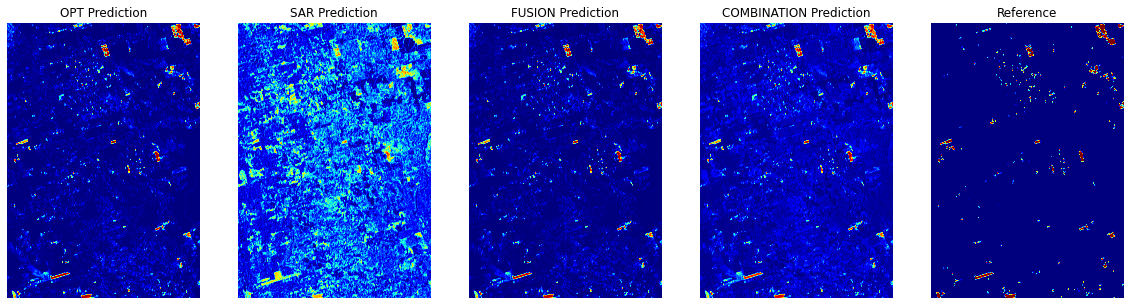

In [17]:
# Plot mean map and reference
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(151)
plt.title('OPT Prediction')
ax1.imshow(mean_prob_opt, cmap ='jet')
ax1.axis('off')

ax1 = fig.add_subplot(152)
plt.title('SAR Prediction')
ax1.imshow(mean_prob_sar, cmap ='jet')
ax1.axis('off')

ax1 = fig.add_subplot(153)
plt.title('FUSION Prediction')
ax1.imshow(mean_prob_fus, cmap ='jet')
ax1.axis('off')

ax1 = fig.add_subplot(154)
plt.title('COMBINATION Prediction')
ax1.imshow(mean_prob_comb, cmap ='jet')
ax1.axis('off')

ax2 = fig.add_subplot(155)
plt.title('Reference')
ax2.imshow(tf.keras.utils.to_categorical(final_mask1, 3)[:,:,1], cmap ='jet')
ax2.axis('off')

In [18]:
# Computing metrics
mean_prob_opt = mean_prob_opt[:final_mask1.shape[0], :final_mask1.shape[1]]
mean_prob_sar = mean_prob_sar[:final_mask1.shape[0], :final_mask1.shape[1]]
mean_prob_fus = mean_prob_fus[:final_mask1.shape[0], :final_mask1.shape[1]]
mean_prob_comb = mean_prob_comb[:final_mask1.shape[0], :final_mask1.shape[1]]

ref1 = np.ones_like(final_mask1).astype(np.float32)

ref1 [final_mask1 == 2] = 0
TileMask = mask_amazon_ts * ref1
GTTruePositives = final_mask1==1
    
Npoints = 50

Pmax_opt = np.max(mean_prob_opt[GTTruePositives * TileMask ==1])
ProbList_opt = np.linspace(Pmax_opt,0,Npoints)

Pmax_sar = np.max(mean_prob_sar[GTTruePositives * TileMask ==1])
ProbList_sar = np.linspace(Pmax_sar,0,Npoints)

Pmax_fus = np.max(mean_prob_fus[GTTruePositives * TileMask ==1])
ProbList_fus = np.linspace(Pmax_fus,0,Npoints)

Pmax_comb = np.max(mean_prob_comb[GTTruePositives * TileMask ==1])
ProbList_comb = np.linspace(Pmax_comb,0,Npoints)


from multiprocessing.pool import Pool
pool = Pool(processes=4)

async_result_opt = pool.apply_async(matrics_AA_recall, (ProbList_opt, mean_prob_opt, final_mask1, mask_amazon_ts, 625))
async_result_sar = pool.apply_async(matrics_AA_recall, (ProbList_sar, mean_prob_sar, final_mask1, mask_amazon_ts, 625))
async_result_fus = pool.apply_async(matrics_AA_recall, (ProbList_fus, mean_prob_fus, final_mask1, mask_amazon_ts, 625))
async_result_comb = pool.apply_async(matrics_AA_recall, (ProbList_comb, mean_prob_comb, final_mask1, mask_amazon_ts, 625))

metrics_opt = async_result_opt.get()
metrics_sar = async_result_sar.get()
metrics_fus = async_result_fus.get()
metrics_comb = async_result_comb.get()
    
#metrics_opt = matrics_AA_recall(ProbList_opt, mean_prob_opt, final_mask1, mask_amazon_ts, 625)
#metrics_sar = matrics_AA_recall(ProbList_sar, mean_prob_sar, final_mask1, mask_amazon_ts, 625)
#metrics_fus = matrics_AA_recall(ProbList_fus, mean_prob_fus, final_mask1, mask_amazon_ts, 625)
#metrics_comb = matrics_AA_recall(ProbList_comb, mean_prob_comb, final_mask1, mask_amazon_ts, 625)

np.save(path_exp+'/acc_metrics_opt.npy',metrics_opt)
np.save(path_exp+'/acc_metrics_sar.npy',metrics_sar)
np.save(path_exp+'/acc_metrics_fus.npy',metrics_fus)
np.save(path_exp+'/acc_metrics_comb.npy',metrics_comb)

In [19]:
# Complete NaN values
metrics_copy_opt = metrics_opt.copy()
metrics_copy_opt = complete_nan_values(metrics_copy_opt)

metrics_copy_sar = metrics_sar.copy()
metrics_copy_sar = complete_nan_values(metrics_copy_sar)

metrics_copy_fus = metrics_fus.copy()
metrics_copy_fus = complete_nan_values(metrics_copy_fus)

metrics_copy_comb = metrics_comb.copy()
metrics_copy_comb = complete_nan_values(metrics_copy_comb)

OPT mAP 0.9338223203344757
SAR mAP 0.7364099266559389
FUSION mAP 0.9400093478102691
COMBINATION mAP 0.9401589174208982


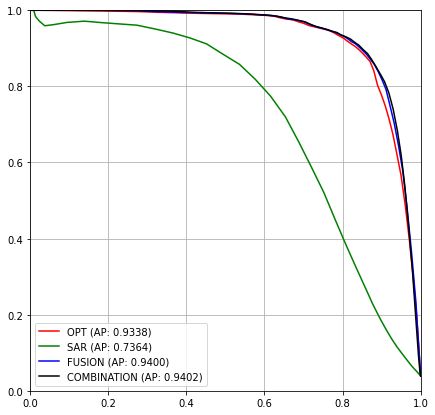

In [20]:
# Comput Mean Average Precision (mAP) score 
Recall_opt = metrics_copy_opt[:,0]
Precision_opt = metrics_copy_opt[:,1]
AA_opt = metrics_copy_opt[:,2]

Recall_sar = metrics_copy_sar[:,0]
Precision_sar = metrics_copy_sar[:,1]
AA_sar = metrics_copy_sar[:,2]

Recall_fus = metrics_copy_fus[:,0]
Precision_fus = metrics_copy_fus[:,1]
AA_fus = metrics_copy_fus[:,2]

Recall_comb = metrics_copy_comb[:,0]
Precision_comb = metrics_copy_comb[:,1]
AA_comb = metrics_copy_comb[:,2]
    
DeltaR_opt = Recall_opt[1:]-Recall_opt[:-1]
AP_opt = np.sum(Precision_opt[:-1]*DeltaR_opt)
print('OPT mAP', AP_opt)

DeltaR_sar = Recall_sar[1:]-Recall_sar[:-1]
AP_sar = np.sum(Precision_sar[:-1]*DeltaR_sar)
print('SAR mAP', AP_sar)

DeltaR_fus = Recall_fus[1:]-Recall_fus[:-1]
AP_fus = np.sum(Precision_fus[:-1]*DeltaR_fus)
print('FUSION mAP', AP_fus)

DeltaR_comb = Recall_comb[1:]-Recall_comb[:-1]
AP_comb = np.sum(Precision_comb[:-1]*DeltaR_comb)
print('COMBINATION mAP', AP_comb)

# Plot Recall vs. Precision curve
plt.figure(figsize=(7,7))
plt.plot(metrics_copy_opt[:,0],metrics_copy_opt[:,1], 'r-', label = f'OPT (AP: {AP_opt:.4f})')
plt.plot(metrics_copy_sar[:,0],metrics_copy_sar[:,1], 'g-', label = f'SAR (AP: {AP_sar:.4f})')
plt.plot(metrics_copy_fus[:,0],metrics_copy_fus[:,1], 'b-', label = f'FUSION (AP: {AP_fus:.4f})')
plt.plot(metrics_copy_comb[:,0],metrics_copy_comb[:,1], 'k-', label = f'COMBINATION (AP: {AP_comb:.4f})')
plt.legend(loc="lower left")
ax = plt.gca()
ax.set_ylim([0,1])
ax.set_xlim([0,1])
#plt.plot(metrics_copy[:,0],metrics_copy[:,2])
plt.grid()